# Aprenentatge Automàtic per a Xarxes (ML4Net)
## Seminar 5

### 1 - Part I: ML model definition

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the ML model
def create_model():
    model = models.Sequential([
        layers.Input(shape=(270,)),  # Input shape for flattened CSI matrix (30x3x3)
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(5, activation='softmax')  # 5 classes: wave, push, crouch, sitdown, bend
    ])
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

We define a simple fully connected neural network to classify CSI-based input features.
The input is a flattened CSI matrix of shape (270,), originally 30 samples of 3x3 (30x3x3).
The network has two hidden layers (128 and 64 units) with ReLU activation and Dropout (0.2) to avoid overfitting.


### 2 - Part II: Preparation of the FL setting

Mounted at /content/drive


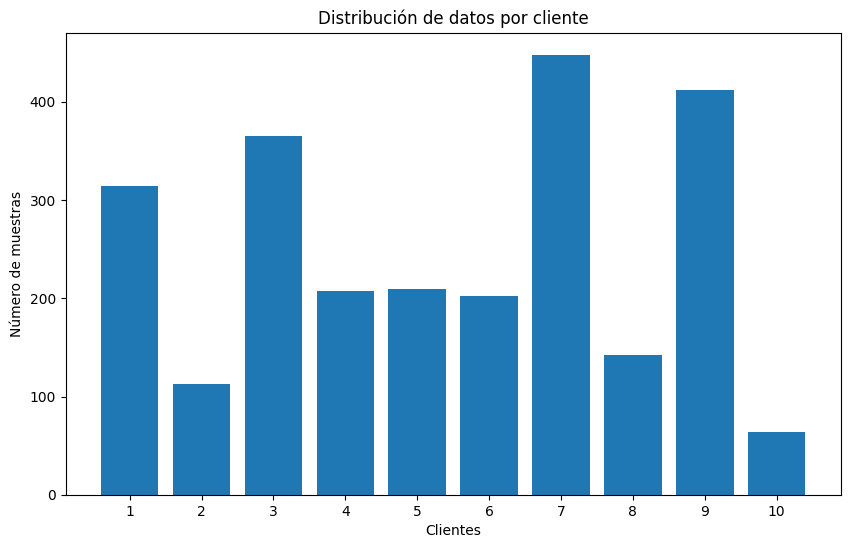

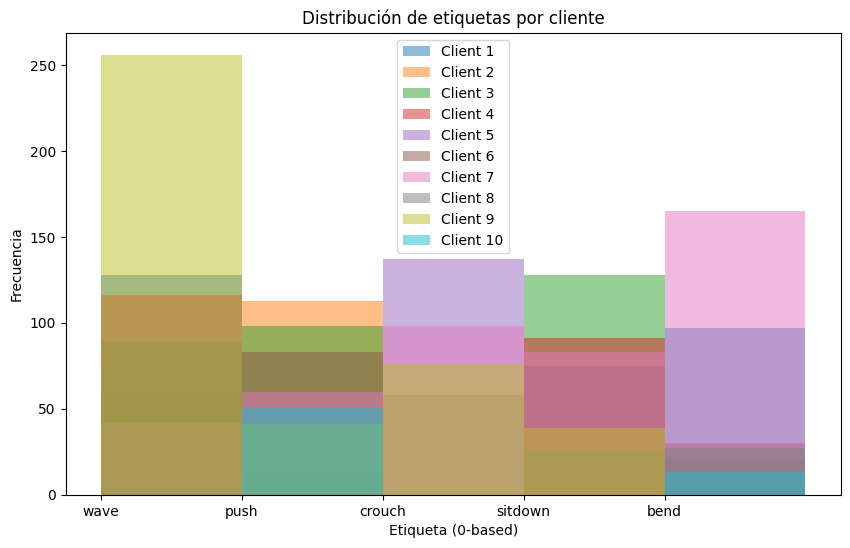

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from google.colab import drive
import os
import matplotlib.pyplot as plt

drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/3r/ML4N/MLforNetworks/dataset_Seminar5/'
CLIENT_DATA_PATH = os.path.join(BASE_PATH, 'client_datasets/')
NUM_CLIENTS = 10

# Carga y preprocesado de datos por cliente
def load_client_data(client_id):
    features = pd.read_csv(f'{CLIENT_DATA_PATH}client_{client_id}_features.csv', header=None).values
    labels = pd.read_csv(f'{CLIENT_DATA_PATH}client_{client_id}_labels.csv', header=None).values.flatten()

    # Remapeo de etiquetas inválidas al rango [1, 5]
    invalid_mask = (labels < 1) | (labels > 5)
    if np.any(invalid_mask):
        labels = (labels - 1) % 5 + 1

    labels = labels - 1  # Reajustamos a rango [0, 4]
    return features, labels

# Cargar datos de prueba
def load_test_data():
    features = pd.read_csv(f'{BASE_PATH}test_features.csv', header=None).values
    labels = pd.read_csv(f'{BASE_PATH}test_labels.csv', header=None).values.flatten()

    invalid_mask = (labels < 1) | (labels > 5)
    if np.any(invalid_mask):
        labels = (labels - 1) % 5 + 1

    labels = labels - 1
    return features, labels

# Cargar datasets de todos los clientes
client_datasets, data_sizes, all_labels = [], [], []
for i in range(1, NUM_CLIENTS + 1):
    X, y = load_client_data(i)
    dataset = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(1000).batch(32)
    client_datasets.append((X, y, dataset))
    data_sizes.append(len(X))
    all_labels.append(y)

X_test, y_test = load_test_data()
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Agregación federada usando FedAvg
def fed_avg_aggregation(client_models, client_data_sizes):
    total_samples = sum(client_data_sizes)
    weights = client_models[0].get_weights()
    aggregated_weights = [np.zeros_like(w) for w in weights]

    for model, size in zip(client_models, client_data_sizes):
        client_weights = model.get_weights()
        for i in range(len(aggregated_weights)):
            aggregated_weights[i] += client_weights[i] * (size / total_samples)

    return aggregated_weights

# Visualización distribución de datos por cliente
plt.figure(figsize=(10, 6))
plt.bar(range(1, NUM_CLIENTS + 1), data_sizes)
plt.xlabel('Clientes')
plt.ylabel('Número de muestras')
plt.title('Distribución de datos por cliente')
plt.xticks(range(1, NUM_CLIENTS + 1))
plt.show()

# Visualización de etiquetas por cliente
plt.figure(figsize=(10, 6))
for i in range(NUM_CLIENTS):
    plt.hist(all_labels[i], bins=range(6), alpha=0.5, label=f'Client {i+1}')
plt.xlabel('Etiqueta (0-based)')
plt.ylabel('Frecuencia')
plt.title('Distribución de etiquetas por cliente')
plt.legend()
plt.xticks(range(5), ['wave', 'push', 'crouch', 'sitdown', 'bend'])
plt.show()


This part focuses on loading and preparing the data for each of the 10 clients. Each client has their own CSV files for features and labels. To handle some invalid label values, we remap them into the valid range (1–5) and then shift them to 0-based indexing for training. We use tensorflow dataset API to shuffle and batch the data.

Additionally, we prepare a centralized test set and visualize both the number of samples and label distributions per client. This helps us understand the data imbalance, which is important in a federated learning context.

Finally, we implement the FedAvg algorithm, which averages client model weights based on their data sizes.

###  3 - Part III: Collaborative training of the model

Round 1/50
Test accuracy after round 1: 0.2380
Round 2/50
Test accuracy after round 2: 0.2520
Round 3/50
Test accuracy after round 3: 0.2180
Round 4/50
Test accuracy after round 4: 0.1840
Round 5/50
Test accuracy after round 5: 0.2500
Round 6/50
Test accuracy after round 6: 0.2740
Round 7/50
Test accuracy after round 7: 0.1860
Round 8/50
Test accuracy after round 8: 0.1720
Round 9/50
Test accuracy after round 9: 0.1720
Round 10/50
Test accuracy after round 10: 0.3220
Round 11/50
Test accuracy after round 11: 0.3240
Round 12/50
Test accuracy after round 12: 0.3120
Round 13/50
Test accuracy after round 13: 0.3260
Round 14/50
Test accuracy after round 14: 0.3180
Round 15/50
Test accuracy after round 15: 0.3020
Round 16/50
Test accuracy after round 16: 0.3140
Round 17/50
Test accuracy after round 17: 0.3200
Round 18/50
Test accuracy after round 18: 0.3160
Round 19/50
Test accuracy after round 19: 0.2800
Round 20/50
Test accuracy after round 20: 0.2380
Round 21/50
Test accuracy after round 

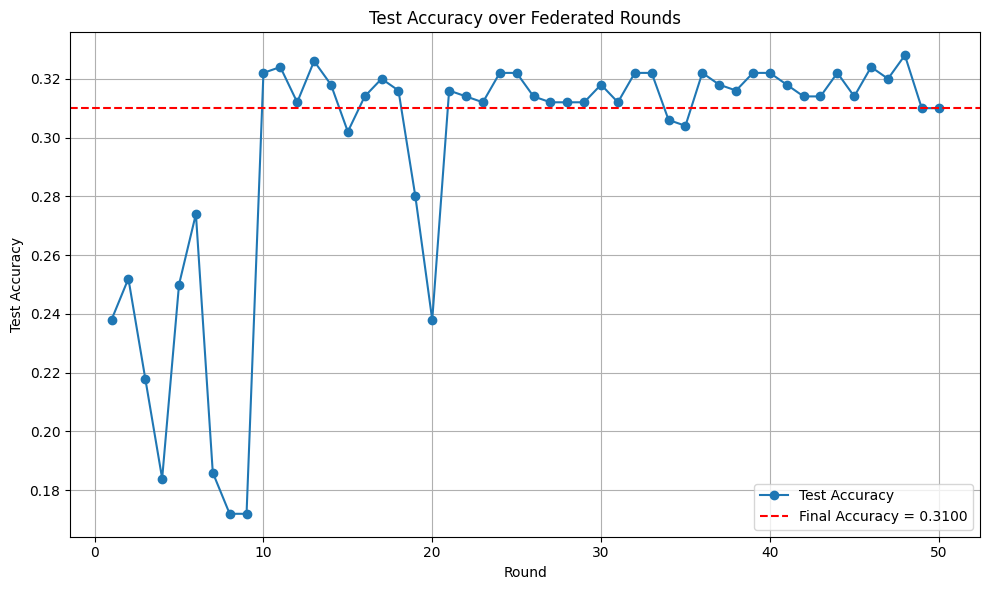

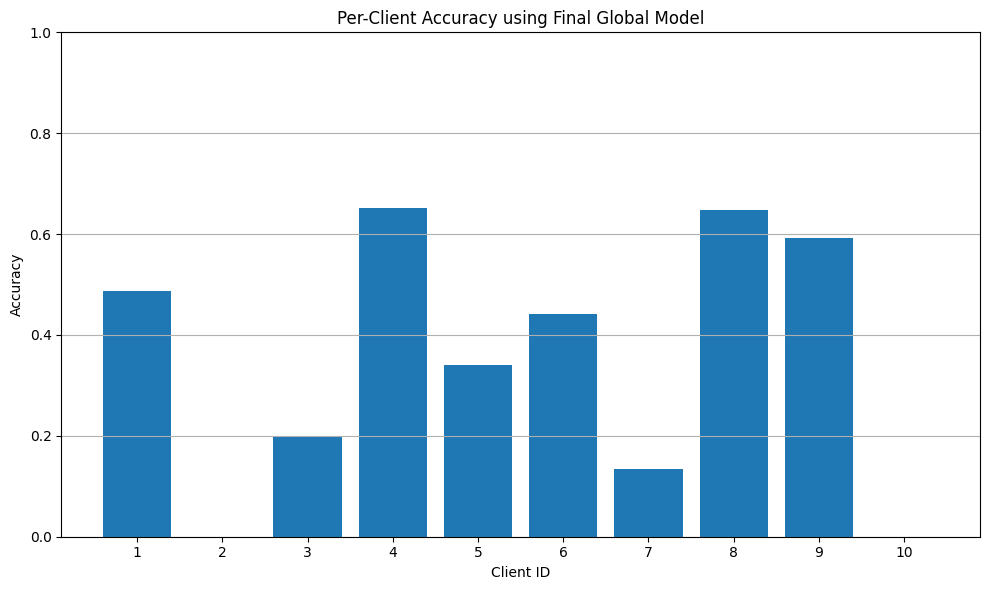

In [6]:
global_model = create_model()

NUM_ROUNDS = 50
CLIENTS_PER_ROUND = 5
LOCAL_EPOCHS = 5

accuracy_history = []

for round_num in range(NUM_ROUNDS):
    print(f'Round {round_num + 1}/{NUM_ROUNDS}')

    selected_clients = random.sample(range(NUM_CLIENTS), CLIENTS_PER_ROUND)

    client_models, client_data_sizes = [], []

    for client_id in selected_clients:
        client_model = create_model()
        client_model.set_weights(global_model.get_weights())
        _, _, client_dataset = client_datasets[client_id]
        client_model.fit(client_dataset, epochs=LOCAL_EPOCHS, verbose=0)
        client_models.append(client_model)
        client_data_sizes.append(len(client_datasets[client_id][0]))

    # Aggregation and evaluation
    new_weights = fed_avg_aggregation(client_models, client_data_sizes)
    global_model.set_weights(new_weights)
    _, test_accuracy = global_model.evaluate(test_dataset, verbose=0)
    accuracy_history.append(test_accuracy)
    print(f'Test accuracy after round {round_num + 1}: {test_accuracy:.4f}')

# Final evaluation
_, final_accuracy = global_model.evaluate(test_dataset, verbose=0)
print(f'\nFinal Test Accuracy: {final_accuracy:.4f}')

# Save the trained model
global_model.save('/content/drive/MyDrive/3r/ML4N/MLforNetworks/dataset_Seminar5/global_model.keras')

# Plot accuracy over rounds with horizontal line
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_ROUNDS + 1), accuracy_history, marker='o', label='Test Accuracy')
plt.axhline(y=final_accuracy, color='r', linestyle='--', label=f'Final Accuracy = {final_accuracy:.4f}')
plt.title('Test Accuracy over Federated Rounds')
plt.xlabel('Round')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot per-client accuracy using final model
client_accuracies = []
for client_id in range(NUM_CLIENTS):
    X, y, _ = client_datasets[client_id]
    eval_dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(32)
    _, acc = global_model.evaluate(eval_dataset, verbose=0)
    client_accuracies.append(acc)

plt.figure(figsize=(10, 6))
plt.bar(range(1, NUM_CLIENTS + 1), client_accuracies)
plt.title('Per-Client Accuracy using Final Global Model')
plt.xlabel('Client ID')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(range(1, NUM_CLIENTS + 1))
plt.grid(axis='y')
plt.tight_layout()
plt.show()


We simulate the federated learning process. The global model is trained across 50 epochs. In each round, a random subset of 5 out of 10 clients is selected. Each selected client receives the current global model, trains it locally for 5 epochs on their own data, and returns the updated weights. These weights are then combined using the FedAvg algorithm, which weighs each client’s contribution according to the size of their dataset. The updated global model is evaluated on a separate test set, and its accuracy is stored after each round.

The first plot shows how the test accuracy of the global model changes over the course of 50 federated training rounds. At the beginning, the accuracy is low and unstable, which is expected as the model is still learning from the local client updates. Around round 10, the accuracy improves and becomes more consistent, staying relatively stable for the rest of the training. The red dashed line marks the final test accuracy, which is around 0.31. While the model does improve over time, the overall accuracy does not reach very high levels.


The second plot shows how well the final global model performs on each individual client’s local dataset. The results vary a lot between clients. Some clients, like client 4, 8, and 9, show high accuracy (above 60%), meaning the model works well for their data. However, other clients, such as client 3 and 7, have low accuracy, showing that the model struggles with their data. This difference happens because each client likely has different kinds of data, and the global model cannot fit all of them equally well.